In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv
/kaggle/input/digit-recognizer/sample_submission.csv


In [2]:
import tensorflow as tf
from keras.layers import *
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils import plot_model, to_categorical
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
#resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
#tf.config.experimental_connect_to_cluster(resolver)
#tf.tpu.experimental.initialize_tpu_system(resolver)

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


# Load dataset

In [4]:
def load_dataset():
    train = pd.read_csv('../input/digit-recognizer/train.csv')
    label = train.pop('label')    
    return train, label, label.nunique()

X_train_orig, Y_train_orig, classes = load_dataset()
m = X_train_orig.shape[0]

def load_quizset():
    quiz = pd.read_csv('../input/digit-recognizer/test.csv')
    return quiz

X_quiz_orig = load_quizset()
mq = X_quiz_orig.shape[0]

# Reshape and Normalize image vectors
X_train = X_train_orig.to_numpy().reshape((-1,28,28,1))/255.0
X_quiz = X_quiz_orig.to_numpy().reshape((-1,28,28,1))/255.0

# one hot encoding
Y_train = to_categorical(Y_train_orig.to_numpy())

print("Training examples = ", str(m))
print("X_train shape: " + str(X_train.shape))
print("Y_train shape: " + str(Y_train.shape))
print("Quiz examples = ", str(mq))
print("X_quiz shape: " + str(X_quiz.shape))

# each pic 28x28x1=784
# train 42000 pic

Training examples =  42000
X_train shape: (42000, 28, 28, 1)
Y_train shape: (42000, 10)
Quiz examples =  28000
X_quiz shape: (28000, 28, 28, 1)


# check data

In [5]:
X_train[np.isnan(X_train)]

array([], dtype=float64)

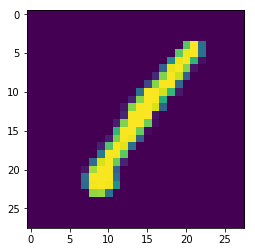

In [6]:
plt.imshow(X_train[0][:,:,0])

# Data augmentation

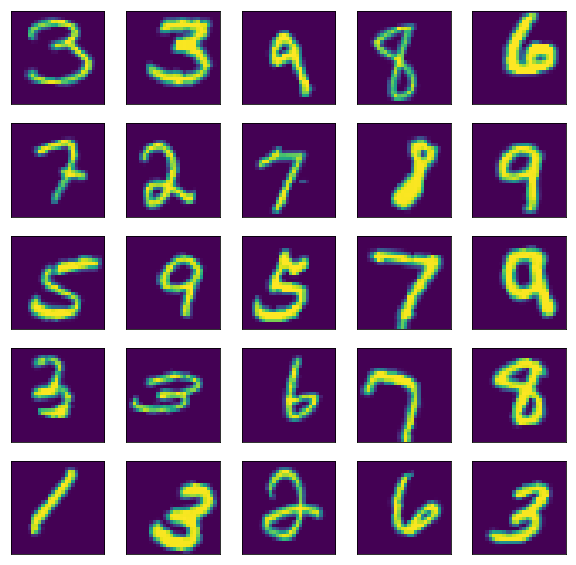

In [7]:
# augmentation generator
train_image_gen = ImageDataGenerator(
    #featurewise_center=True,
    #featurewise_std_normalization=True,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    #brightness_range=(0.3,2),
    shear_range=5,
    zoom_range=0.1,
    validation_split=0.2
    )
train_image_gen.fit(X_train)

# Generally only apply data augmentation to the training examples.
val_image_gen = ImageDataGenerator()

# check results
data_gen = train_image_gen.flow(X_train,seed=130)
plt.figure(figsize=(10,10))
i=0
for data in data_gen[1]:
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)    
    plt.imshow(image.array_to_img(data_gen[0][i]))
    #print(data.shape)
    i = i+1
    if i > 24:
        break


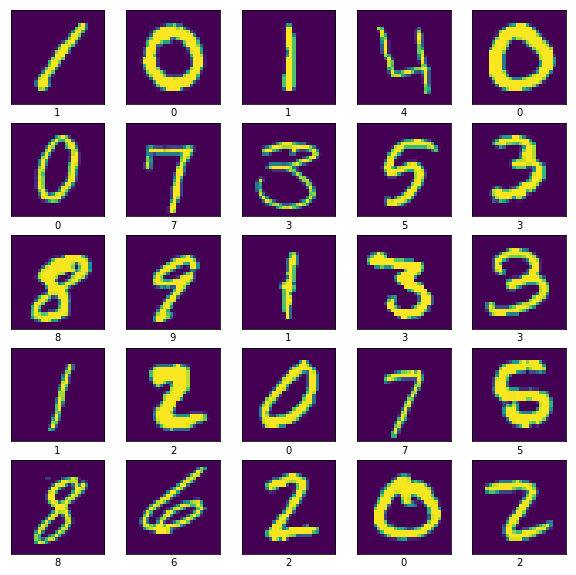

In [8]:
# img check
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image.array_to_img(X_train[i]))
    plt.xlabel(np.argmax(Y_train[i]))
plt.show()

# Model
* ConvNet

In [9]:
def model(input_shape,classes):
    """
    input_shape: height, width, channels as tuple
    """       
    # input placeholder
    X_input = Input(input_shape)
    
    # zero padding
    X = ZeroPadding2D((3,3))(X_input)
    
    # Stage1 CNV -> BN -> RELU -> MAXPOOL -> Dropout
    X = Conv2D(32,(7,7), strides=(1,1), name='conv1a')(X)
    #X = BatchNormalization(axis=3,name='bn_conv1a')(X)
    X = Activation('relu')(X)

    X = Conv2D(64,(7,7), strides=(1,1), name='conv1b')(X)
    #X = BatchNormalization(axis=3,name='bn_conv1b')(X)
    X = Activation('relu')(X)

    X = MaxPooling2D((2,2))(X)
    X = Dropout(0.3)(X)
    
    #X_shortcut = X    

    # Stage2 CNV -> BN -> RELU -> MAXPOOL -> Dropout
    X = Conv2D(128,(5,5), strides=(1,1), name='conv2a')(X)
    #X = BatchNormalization(axis=3,name='bn_conv2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(256,(5,5), strides=(1,1), name='conv2b')(X)
    #X = BatchNormalization(axis=3,name='bn_conv2b')(X)
    X = Activation('relu')(X)

    X = MaxPooling2D((2,2), strides=(2,2))(X)
    X = Dropout(0.3)(X)
 
    #X_shortcut = Conv2D(128,(3,3), strides=(1,1), padding='valid', name='conv2')(X_shortcut)
    #X_shortcut = BatchNormalization(axis=3,name='bn_conv2')(X_shortcut)
    #X = Add()([X,X_shortcut])
    #X = LeakyReLU()(X)
       
    # Flatten X + FullyConnected
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc'+str(classes))(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='MyModel')
    
    return model

model(X_train.shape[1:],classes).summary()



Model: "MyModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 34, 34, 1)         0         
_________________________________________________________________
conv1a (Conv2D)              (None, 28, 28, 32)        1600      
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
conv1b (Conv2D)              (None, 22, 22, 64)        100416    
_________________________________________________________________
activation_2 (Activation)    (None, 22, 22, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 64)        0   

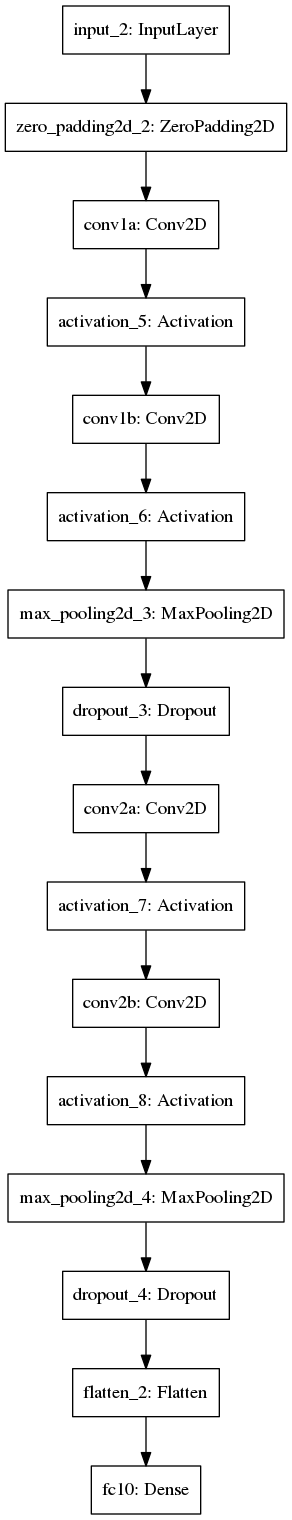

In [10]:
plot_model(model(X_train.shape[1:],classes))

# Train

In [11]:
# learning rate reduction
learning_rate_reduction = ReduceLROnPlateau(monitor='val_categorical_accuracy', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.3, 
                                            min_lr=1e-05)

In [12]:
#strategy = tf.distribute.experimental.TPUStrategy(resolver)
#strategy = tf.distribute.MirroredStrategy()
#with strategy.scope():
BATCH_SIZE=4096
EPOCHS=1000
mymodel = model(X_train.shape[1:],classes)
mymodel.compile(optimizer=Adam(),
                loss='categorical_crossentropy',
                metrics=['categorical_accuracy','categorical_crossentropy'])
history = mymodel.fit(train_image_gen.flow(x=X_train,y=Y_train,batch_size=BATCH_SIZE),
                      #x=X_train, y=Y_train, batch_size=BATCH_SIZE,
                      epochs=EPOCHS, shuffle=True,
                      #validation_split=0.2,
                      validation_data=val_image_gen.flow(x=X_train,y=Y_train,batch_size=BATCH_SIZE),
                      #validation_data=Y_train,
                      callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_categorical_crossentropy',patience=16,restore_best_weights=True),
                                learning_rate_reduction])

Epoch 1/1000
11/11 [==============================] - 20s 2s/step - loss: 1.9769 - categorical_accuracy: 0.3577 - categorical_crossentropy: 1.9931 - val_loss: 1.3943 - val_categorical_accuracy: 0.6366 - val_categorical_crossentropy: 1.4013
Epoch 2/1000
11/11 [==============================] - 17s 2s/step - loss: 1.2439 - categorical_accuracy: 0.5902 - categorical_crossentropy: 1.2533 - val_loss: 0.4695 - val_categorical_accuracy: 0.8601 - val_categorical_crossentropy: 0.5010
Epoch 3/1000
11/11 [==============================] - 18s 2s/step - loss: 0.6382 - categorical_accuracy: 0.7993 - categorical_crossentropy: 0.6414 - val_loss: 0.2037 - val_categorical_accuracy: 0.9343 - val_categorical_crossentropy: 0.2210
Epoch 4/1000
11/11 [==============================] - 17s 2s/step - loss: 0.3687 - categorical_accuracy: 0.8888 - categorical_crossentropy: 0.3624 - val_loss: 0.1498 - val_categorical_accuracy: 0.9590 - val_categorical_crossentropy: 0.1392
Epoch 5/1000
11/11 [====================

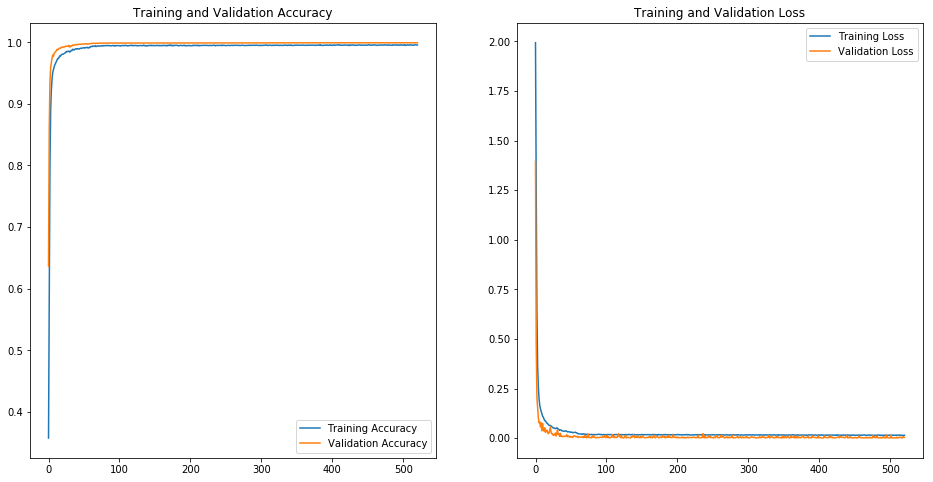

In [13]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Evaluate with "train" datatset
* list predict error

In [14]:
Y_pred = mymodel.predict(X_train)
Y_pred_classes = np.argmax(Y_pred,axis=1)
Y_train_classes = np.argmax(Y_train,axis=1)

errors = (Y_pred_classes - Y_train_classes !=0)
Y_pred_errors = Y_pred_classes[errors]
Y_train_errors = Y_train_classes[errors]
X_train_errors = X_train[errors]
#plt.imshow(X_train_errors)


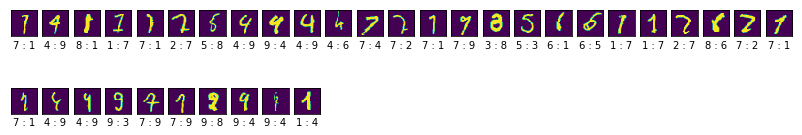

In [15]:
# error img in train
plt.figure(figsize=(14,14))
for i in range(len(Y_pred_errors)):
    plt.subplot(10,25,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image.array_to_img(X_train_errors[i]))
    plt.xlabel("{} : {}".format(Y_pred_errors[i],Y_train_errors[i]))
plt.show()

# Submission

In [16]:
Y_quiz = mymodel.predict(X_quiz)
Y_sub = np.argmax(Y_quiz,axis=1)
Y_sub = pd.Series(Y_sub,name="Label")
submission = pd.concat([pd.Series(range(1,28001),name='ImageId'),Y_sub],axis=1)
submission.to_csv("submission.csv",index=False)